# QuDiPy tutorial: using the charge stability module

This tutorial will show how to use the charge stability module to generate a charge stability diagram using the constant interaction model and then perform the Hough transformation.

This tutorial will be updated to include the generation of the charge stability diagrams using the Hubbard model and also the extraction of parameters from the Hough transformation.

In order for the file to not be too large, the output of the cells has been cleared so you will need to run the cells on your local machine to see the output.

## 1. Add the current location to path
In order for this tutorial to work, you will need to run this from the tutorials folder.

In [31]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

## 2. Import the relevant modules and set plotting parameters

In [32]:
#From module
import qudipy.chargestability.csd_cim as cim
import qudipy.chargestability.csd_analysis as an
#For data maniupulation
import numpy as np
import pandas as pd
#For plotting
import seaborn as sb
import matplotlib.pyplot as plt
#Makes plots bigger (optional)
%matplotlib inline 
plt.rcParams['figure.figsize'] = [12, 12]

## 3. Specify the capacitance of the system you wish to simulate and then initialize the charge stability diagram object
In this tutorial, we will be simulating a double quantum dot system. The parameters follow the naming convention of https://doi.org/10.1103/RevModPhys.75.1. 
The first three parameters are the coupling of the first dot to the left resevoir, $C_l$, the coupling of the second dot to the right resevoir, $C_r$ and the coupling between the dots $C_m$.
The next two parameters are capacitances between gates and dots. $C_{g1}$ is the coupling between dot 1 the plunger gate $V_1$ and $C_{g2}$ is the coupling between dot 2 the plunger gate $V_2$.
These parameters are all that is required to define the system.

In [33]:
# Dot capacitances
c_l = 50 * 10**-18
c_r = 50 * 10**-18
c_m = 5 * 10**-18
# Dot-to-gate capacitances
c_g1 = 1 * 10**-18
c_g2 = 1 * 10**-18
# Initialize Object
csd = cim.CIMCSD(c_l, c_r, c_m, c_g1, c_g2)

## 4. Generate the charge stability diagram
The parameters used to generate the charge stability diagram are as follows:
- `num`: Number of points to sweep each plunger voltage by. The resulting charge stability diagram will by `num` by `num` in size;
- `v1(2)_max`: Maximum voltage to sweep gate 1(2) to. By default, both voltages start at 0 volts, but this can be changed using a keyword argument.

This will generate occupations as a function of voltage.


In [34]:
# Generate charge stability diagram
num = 100
v1_max = 0.15
v2_max = 0.15

csd.generate_csd(v1_max, v2_max, num=num)

## 5. Plot the resulting diagram

In order to plot this charge stability diagram, we must then pass this object to the the CSDAnalysis object.

To simulate real experimental results, we can pass a list of capacitances from each dot to the charge sensor. This list dictates how much a change in the charge of one dot will change the current passing through a charge sensor. The scale of this current is arbitrary (and large in this case since the sensor capacitances are large), but simulates what would be seen in an experiment. 

If you do not pass any capacitance vector, then a colorbar will be created that maps each charge occupation to a unique color. In this case, since the colors are physically meaningless, no derivative of the charge stability diagram will be done and further analysis cannot be completed.

In addition, in order to simulate real experiments with broadened transmission lines, when generating a charge stability diagram you can add an artificial Gaussian blur by setting the optional blur flag to True and specifying a non-zero `blur_sigma`, which is related to the standard deviation of the Gaussian used in the filter, which large `sigma_blur` means more blur. 

For an explanation of the second plot that is printed, see the next section.

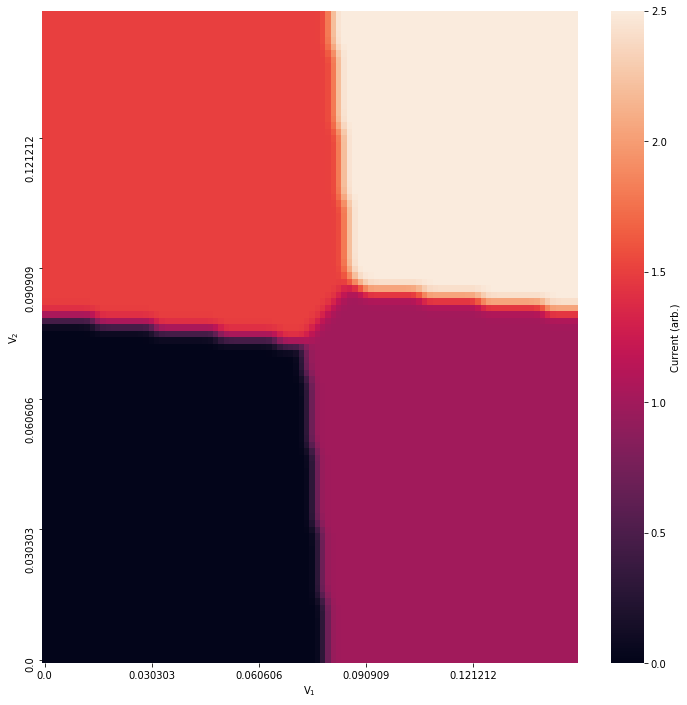

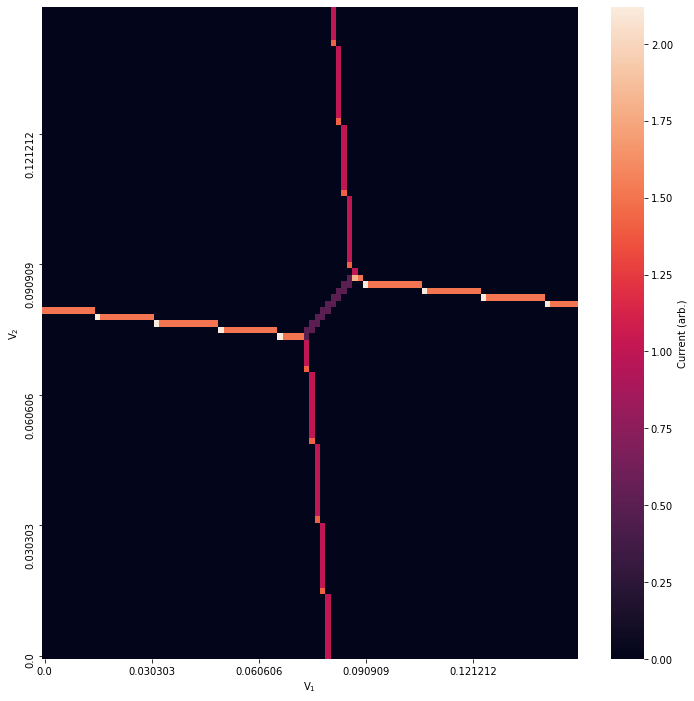

In [35]:
# Initialize the CSDAnalysis object, specifying capacitances and the blurring on the data to be done
c_cs_1 = 1
c_cs_2 = 1.5
csd_an = an.CSDAnalysis(csd, capacitances=[c_cs_1, c_cs_2], blur_sigma=1)
csd_an.plot(derivative=True)

## 6. Find the edges of the charge stability diagram
In order for the Hough transform to be used, we need to have a bitmap of where edges are and aren't in the image. So, we need to run some pre-processing to first find the edges, and then transform that map of edges into a bitmap.

In order to find the edges, we can take the derivative of the above charge stability diagram. This is done automatically when csd_an is initialized, if a list of capacitances is provided. This derivative is the second plot in the cell above.

## 7. Create bitmap from edge data
From that derivative image, we can create a bitmap.

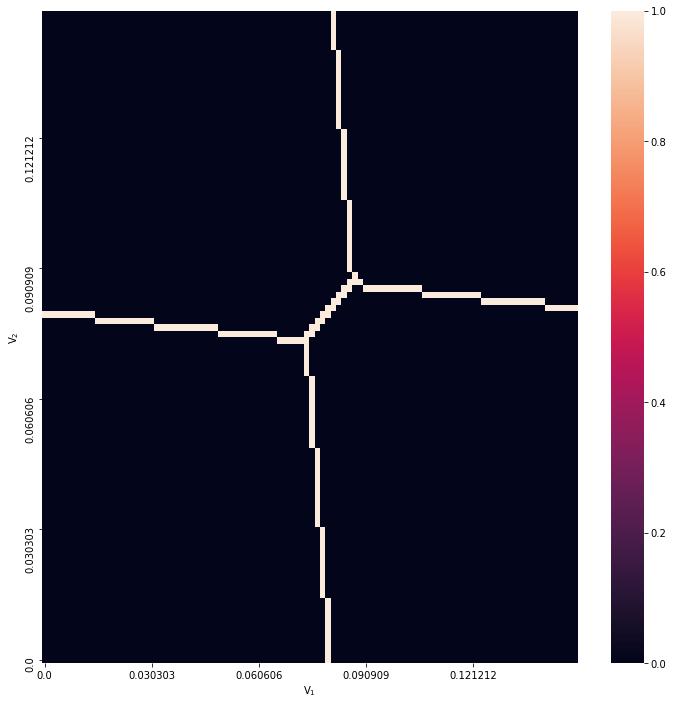

In [36]:
# Generate the bitmap
csd_an.generate_bitmap(98, threshold_type='percentile', plotting=True)

Note that in an actual experiment, the data won't be so clean, so there will be some additional noise. Fortunately, the Hough transform is relatively robust to random noise, but a more quantitative assessment is necessary before deployment. In addition, there is a threshold parameter in the bitmap generation function that allows any noise below a certain level to be ignored, which can help clean up some data as well.

For the purposes of this tutorial, I  will be artificially adding noise to this bitmap to demonstrate that the Hough transform still perfroms as intended. However, in practice this would not be required (since the data will already be noisy).

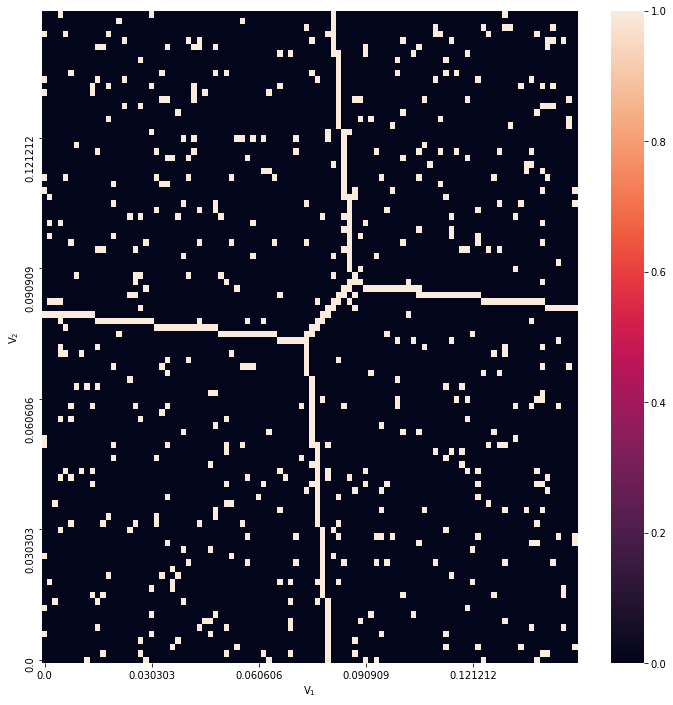

In [30]:
# Adding artificial noise (Will not be needed in practice)
np.random.seed(469230) # fix seed for reproducibility

noise = np.random.rand(*csd_an.csd_bitmap.shape) 
error = 0.05 # error rate of 5%

for index, value in np.ndenumerate(noise):
    noise[index] = 1 if value < error else 0

noise_df = csd_an.csd_bitmap.copy()
noise_df[:] = noise

csd_an.csd_bitmap = csd_an.csd_bitmap + noise_df

r = sb.heatmap(csd_an.csd_bitmap, cbar=True, xticklabels=int(num/5), yticklabels=int(num/5), vmax=1)
r.axes.invert_yaxis()
r.set(xlabel=r'V$_1$', ylabel=r'V$_2$')
plt.show()

Now all the data points that are 0 are set to be ignored when we perform the Hough transform and all the non-zero ones will be included.

## 8. Perform the Hough transform

For some background on the Hough transform, see the wikipedia article (https://en.wikipedia.org/wiki/Hough_transform, Theory and Examples section were most useful for me) and this tutorial that I found particularily useful (https://alyssaq.github.io/2014/understanding-hough-transform/)



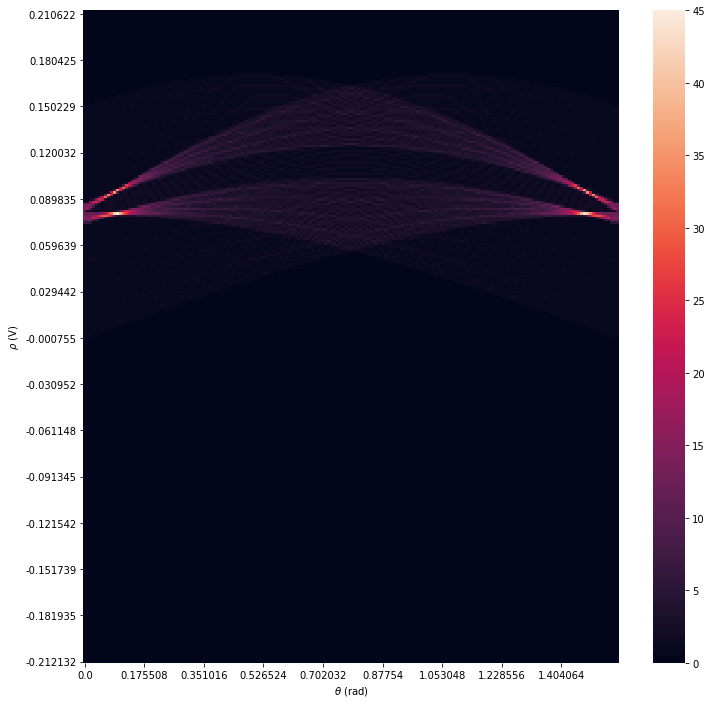

In [37]:
# Function which performs the Hough transform
accumulator, thetas, rhos = csd_an.hough_transform(plotting=True, theta_min=0)

The spots where the counts in the color bar are the highest places where lines fit the best. We can see that there are 4 peaks. These correspond to the 4 large occupation transitions seen in the earlier charge stability diagram.
We can convert from these polar coordinates to the normal slope and intercept using $m = \frac{-\text{cos}(\theta)}{\text{sin}(\theta)}$ and $b = \frac{\rho}{\text{sin}(\theta)}$.

## 9. Peak Finding & Clustering

Next, we need to figure out where the peaks are in order to extract the best fitting lines. In order to do this, we first apply a threshold to function to the Hough transformed result, discarding the pixels in the accumulator with a low amount of votes.

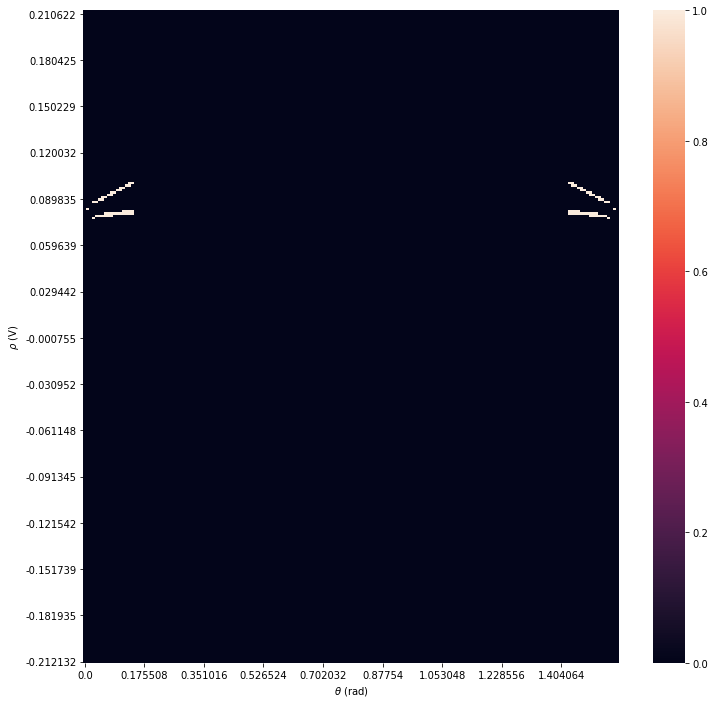

In [38]:
# Function which does the thresholding
accumulator_threshold = csd_an.threshold_hough_accumulator(threshold=99.85, threshold_type='percentile', plotting=True)

From the above thresholded accumulator, we can cluster them into groups, determine the centroid of each group and use that location to convert into the slope and intercept then get the lines which correctly fit the charge stability diagram.

The clustering algorithm is DBSCAN in the scikit module, whose documentation can be found at (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html). The two parameters passed to the hough_clusters function, eps and min_samples, are diretly passed to the clustering algorithm and the results of the clustering algorithm are highly dependent on those parameters, so it is important to understand what they are for optimal performance, so I recommend looking at the documentation linked above.

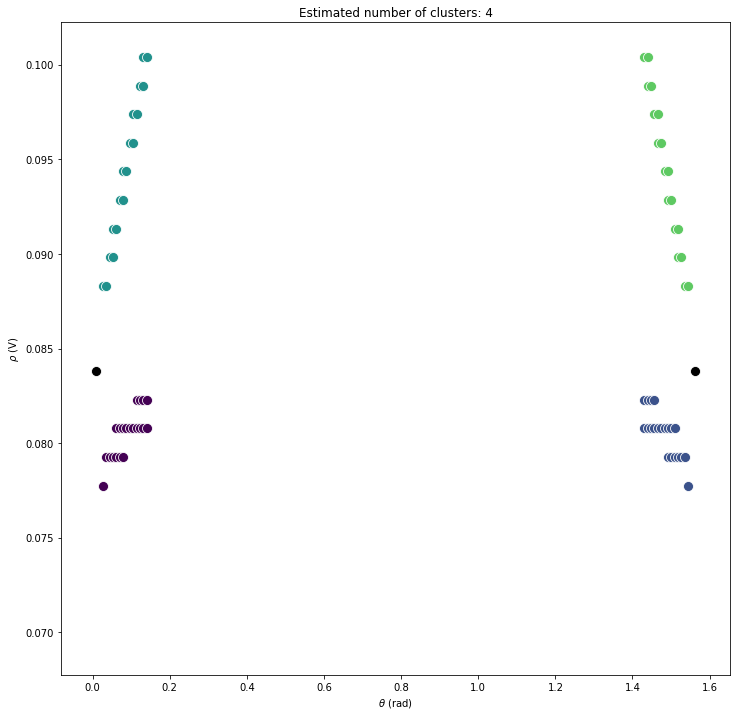

In [39]:
# Parameters corresponding to scanning radius and minimum number of samples in scanning radius
# See link to docs in paragraph above for more information
eps = 2.5
min_samples = 2

centroids = csd_an.hough_cluster(eps, min_samples, plotting=True)

Once the clustering is done, we discard the clusters which are simply noise as opposed to a real signal and use those to create the lines we use to demarcate the charge transition regions. This can be done by the function call below.

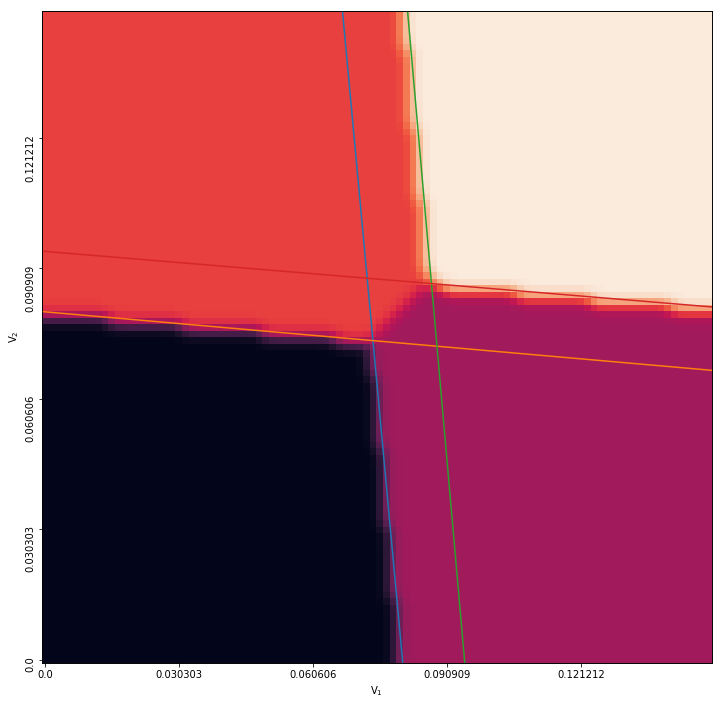

In [40]:
csd_an.plot_csd_with_lines()

We can see that the fitted lines do a pretty good job of retracing the charge transitions lines.

## 10. Extracting Triple Points

Next we would like to identify not only the lines of charge transitions but also find the location of the triple points. These points are not only useful to know in it of themselves, but they will also allow us to construct the shorter transition (the (1,0)-(0,1) transition in this case) line between them that is hard to identify directly using the Hough transformations since it is short relative to the other lines here. Furthermore, it will allow us to know where the long line transitions in the previous figure are meant to end.

To do this, we do the two function calls in the cell below. Note that these two functions are not general, so this will only work correctly in the case of a charge stability diagram with 4 charge regions similar to the one that was generated for this example.

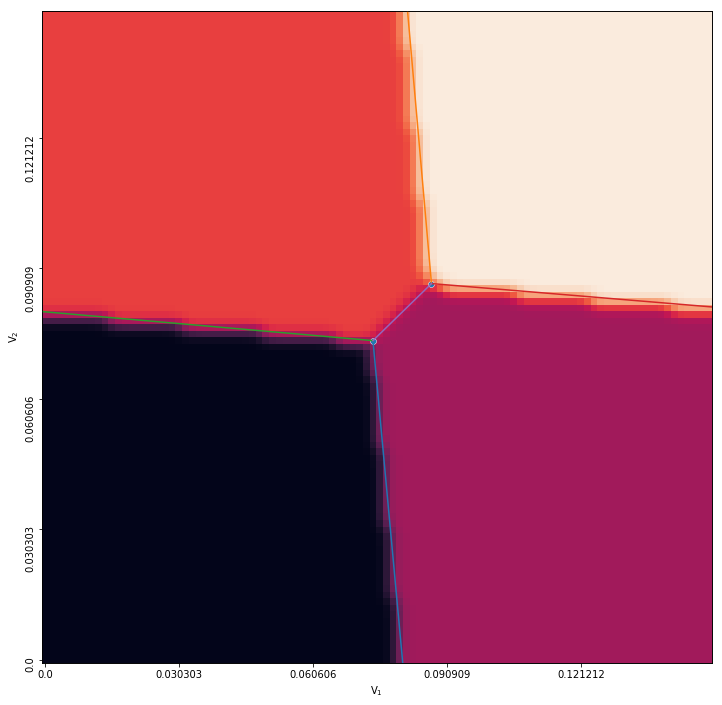

In [41]:
triple_points = csd_an.find_tripletpoints()
csd_an.plot_triple_points()

As we can see, the triple points and line transitions are properly characterized in this case.

## 11. Extracting Hubbard Parameters

We can extract various parameters for the Hubbard Hamiltonian model from the charge stability diagram, using the triple points and transition lines. The function below, `hubbard_from_csd`, extracts the inter- and intra- dot Coulomb energies (U_12, U_1, and U_2, respectively), and lever arms for each dot (alpha_1 and alpha_2) for a given charge stability diagram. These parameters are stored in a dictionary, which is returned from the function and stored as an attribute in the CSD_Analysis object.

In [42]:
# extract Hubbard parameters
hubbard_params = csd_an.hubbard_from_csd()
print ("Hubbard Parameters: ", hubbard_params) # Dictionary of Hubbard Parameters extracted from CSD

Hubbard Parameters:  {'U_12': 0.013111507792534088, 'alpha_1': 0.9193325425735983, 'alpha_2': 0.9193325425735983, 'U_1': 149.42625168124843, 'U_2': 149.42625168124889}


## 12. Finding Addition Voltages, $\Delta V_{1(2)}$
It is useful to know $\Delta V_{1(2)}$, the voltage difference required to add increase the charge occupancy on dot 1(2) by one electron. The CSD we generated earlier has only one charge transition in each direction (this is a requirement to perform the Hough Transform, and subsequently extract the Hubbard parameters). In order extract the addition voltages, we need to extend the axes to capture a minimum of two charge transitions in each dot. Below, we will create a second CSDAnalysis object (using the same capacitance values as before), extending the axes (ie. v1(2)_max) to `0.3` from `0.15`.

In [45]:
# Creating a second CSDAnalysis object

# Dot capacitances
c_l = 50 * 10**-18
c_r = 50 * 10**-18
c_m = 5 * 10**-18
# Dot-to-gate capacitances
c_g1 = 1 * 10**-18
c_g2 = 1 * 10**-18
# Initialize Object
csd_2 = cim.CIMCSD(c_l, c_r, c_m, c_g1, c_g2)

# Generate CSD with higher v1(2)_max to capture two charge transitions
num = 100
v1_max = 0.30
v2_max = 0.30

csd_2.generate_csd(v1_max, v2_max, num=num)

# Initialize the CSDAnalysis object, specifying capacitances and the blurring on the data to be done
c_cs_1 = 1
c_cs_2 = 1.5
csd_an_2 = an.CSDAnalysis(csd_2, capacitances=[c_cs_1, c_cs_2], blur_sigma=1)

Given a charge stability diagram with a minimum of two charge transitions in the $V_{1(2)}$ direction (ie horizonally(vertically)), `delta_V_from_csd()` finds these values, returning a tuple of $\Delta V_{1(2)}$ values as ($\Delta V_{1}$, $\Delta V_{2}$). To do this, the function finds voltage values at which charge transitions occur, indicated by spikes in the CSD derivative value along a 1D horizontal(vertical) slice. $\Delta V_{1(2)}$ values will be calculated using the first two charge transitions in dot 1(2).

The function will print the charge transition values, followed by an optional plot of the dot 1(2) voltage vs CSD derivative along the 1D horizontal(vertical) slice if `plot_der=True` (eg. `delta_V_from_csd(plot_der=True)`). Comparing the charge transition values with the peaks in the CSD derivative (voltage values should match) allows us to double-check that the charge transition values were extracted properly by the function (ie. not charge noise, etc). The default is `plot_der=False`, so values will not print or plot automatically.

transitions, dot 1:  [0.081818, 0.242424]
transitions, dot 2:  [0.081818, 0.242424]
Addition Voltages for (Dot 1, Dot 2): (0.160606, 0.160606)


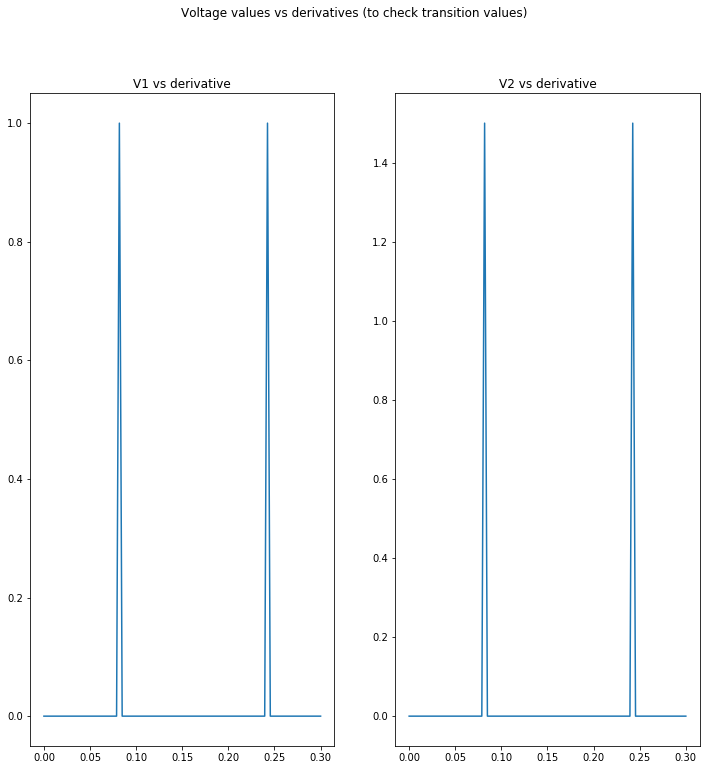

In [47]:
# extract delta_V1(2) values
delta_V = csd_an_2.delta_V_from_csd(plot_der=True)
print ("Addition Voltages for (Dot 1, Dot 2):", delta_V)